In [ ]:
import pandas as pd
import numpy as np
import holidays
from datetime import datetime
import os

## Decision Making:
- Since openweather only offer hourly prediction weather data, we predict bikes data hourly
- To make the model be able to capture the hour feature's nature, we use cyclical encoding for hour feature
- Since we are going to train each model for each station, we drop station_id and capacity in each station's data
- We estimate average temperature, relative humidity and barometric pressure from max, min and standard deviation and merge them averagely into each hour

## Chosen features:
- hour
- temperature_celsius
- relative_humidity_percent
- barometric_pressure_hpa
- is_holiday
- is_weekend

## Predictions:
- num_bikes_available
- num_docks_available

In [ ]:
# Load the dataset
if os.path.isfile('final_merged_data.csv'):
    data = pd.read_csv("final_merged_data.csv")
    df = pd.DataFrame()
    
    # choose relevant features, time as index, station_id as index for each station data file
    df['time'] = data['last_reported']
    df['station_id'] = data['station_id']
    # estimate average temperature, relative humidity and barometric pressure from max, min and standard deviation
    df['temperature_celsius'] = (data['max_air_temperature_celsius'] + data['min_air_temperature_celsius']) / 2 + (data['air_temperature_std_deviation'] / np.sqrt(3))
    df['relative_humidity_percent'] = (data['max_relative_humidity_percent'] + data['min_relative_humidity_percent']) / 2 + (data['relative_humidity_std_deviation'] / np.sqrt(3))
    df['barometric_pressure_hpa'] = (data['max_barometric_pressure_hpa'] + data['min_barometric_pressure_hpa']) / 2 + (data['barometric_pressure_std_deviation'] / np.sqrt(3))
    # add is_holiday and is_weekend
    ireland_holidays = holidays.country_holidays('IE')
    df['is_holiday'] = data['last_reported'].apply(lambda x: x in ireland_holidays)
    df['is_weekend'] = data['last_reported'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday() in [5, 6])
    # target features
    df['available_bikes'] = data['num_bikes_available']
    df['available_docks'] = data['num_docks_available']
    
    # deal with each station's data by merging hourly data and imputing missing values
    for station_id in df['station_id'].unique():
        df_station = pd.DataFrame(df[df['station_id'] == station_id])
        # Resample data to hourly frequency and take the mean
        df_station['time'] = pd.to_datetime(df_station['time'])
        df_station.set_index('time', inplace=True)
        df_station = df_station.resample('h').mean()
        # Interpolate missing hourly values using the nearest available value
        df_station = df_station.interpolate(method='nearest')
        # Round the values after taking the mean for each hour
        df_station['available_bikes'] = df_station['available_bikes'].round()
        df_station['available_docks'] = df_station['available_docks'].round()
        df_station['temperature_celsius'] = df_station['temperature_celsius'].round(2)
        df_station['relative_humidity_percent'] = df_station['relative_humidity_percent'].round(2)
        df_station['barometric_pressure_hpa'] = df_station['barometric_pressure_hpa'].round(2)
        # station_id is constant column for each station data file, so drop it
        df_station.drop(columns=['station_id'], inplace=True)
        # Cyclical Encoding for hour feature
        df_station['hour_sin'] = np.sin(2 * np.pi * df_station.index.hour / 23.0).round(6)
        df_station['hour_cos'] = np.cos(2 * np.pi * df_station.index.hour / 23.0).round(6)
        # save the data for each station
        df_station.to_csv(f'station_{station_id}.csv', index=True)
        
    # station_70's data is corrupt, contain only 59 rows of data and all available_bikes and available_docks are 0
    # so I will not train the model on this station
    station_70 = data[data['station_id']==70]
    print(f"Number of rows for station 70: {len(station_70)}")
    if (station_70['num_bikes_available'] == 0).all() and (station_70['num_docks_available'] == 0).all():
        print("All available_bikes and available_docks are 0 for station 70")

In [ ]:
# example data
data = pd.read_csv(f'station_1.csv', parse_dates=['time'], index_col='time')
data

In [ ]:
# for station_id in range(1,118):
#     if (station_id == 70):
#         continue
#     df_station = pd.read_csv(f'station_{station_id}.csv')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed

# Load dataset
data = pd.read_csv(f'station_1.csv', parse_dates=['time'], index_col='time')

# Features and target variables
features = ['hour_sin', 'hour_cos','temperature_celsius', 'relative_humidity_percent', 'barometric_pressure_hpa', 'is_holiday', 'is_weekend']
targets = ['available_bikes', 'available_docks']

# Normalize the features
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Normalize the targets
target_scaler = MinMaxScaler()
data[targets] = target_scaler.fit_transform(data[targets])

# Move target columns to the last
data = data[[col for col in data.columns if col not in targets] + targets]

# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), 0:-2]  # features
        y = data[i:(i + seq_length), -2:]   # targets
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Sequence length, 24 hours, from 0:00 to 23:00
seq_length = 24

# Create sequences
x, y = create_sequences(data.values, seq_length)

# Split the data
# Since we don't use it to predict future, we simply use the model to capture the relationship between target values and features 
# and try to capture the hourly sequence pattern within 24 hours of a given sequence
# we should shuffle the sequence to avoid bias
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, len(features)), return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(2)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

# Predict using the model
predictions = model.predict(x_test)

# Inverse transform the predictions and actual values
inverse_predictions = []
for prediction in predictions:
    inverse_predictions.append(target_scaler.inverse_transform(prediction))
predictions = np.array(inverse_predictions).reshape(-1,2)
inverse_y_test = []
for y in y_test:
    inverse_y_test.append(target_scaler.inverse_transform(y))
y_test = np.array(inverse_y_test).reshape(-1,2)

# Display the first few predictions and actual values
print("Predictions:")
print(predictions[-1])
print("\nActual Values:")
print(y_test[-1])


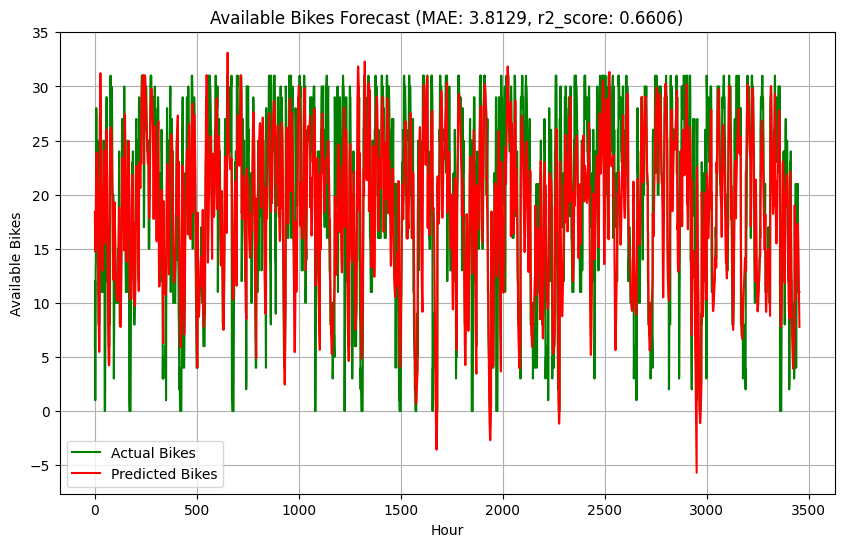

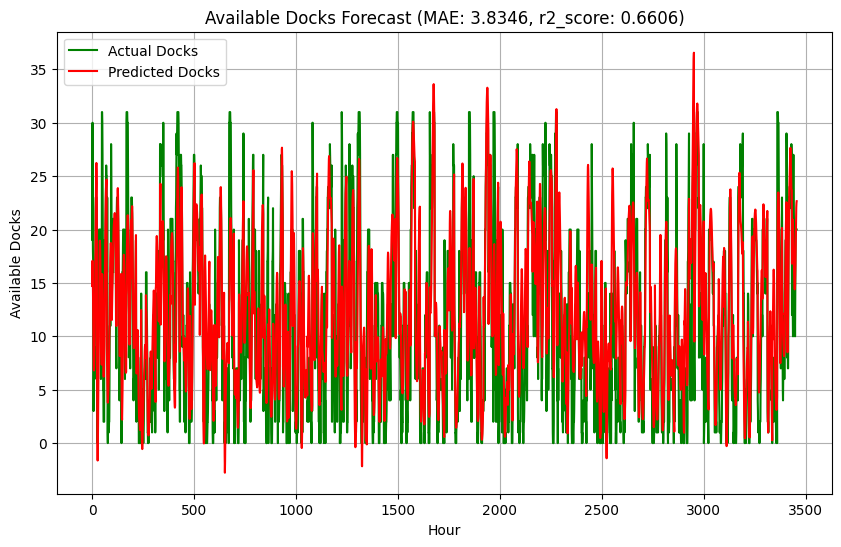

In [110]:
from sklearn.metrics import mean_absolute_error, r2_score
# Calculate MAE
mae_bikes = mean_absolute_error(y_test[:, 0], predictions[:, 0])
r2_score_bikes = r2_score(y_test[:, 0], predictions[:, 0])
mae_docks = mean_absolute_error(y_test[:, 1], predictions[:, 1])
r2_score_docks = r2_score(y_test[:, 1], predictions[:, 1])
import matplotlib.pyplot as plt
# Plot results for available_bikes
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='Actual Bikes', color='green')
plt.plot(predictions[:, 0], label='Predicted Bikes', color='red')
plt.title(f'Available Bikes Forecast (MAE: {mae_bikes:.4f}, r2_score: {r2_score_docks:.4f})')
plt.xlabel('Hour')
plt.ylabel('Available Bikes')
plt.legend()
plt.grid(True)
plt.show()

# Plot results for available_docks
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 1], label='Actual Docks', color='green')
plt.plot(predictions[:, 1], label='Predicted Docks', color='red')
plt.title(f'Available Docks Forecast (MAE: {mae_docks:.4f}, r2_score: {r2_score_docks:.4f})')
plt.xlabel('Hour')
plt.ylabel('Available Docks')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv(f'station_1.csv', parse_dates=['time'], index_col='time')

# Convert 'time' to datetime
data['time'] = pd.to_datetime(data['time'])

# Extract time features

# Drop the original 'time' column
data.drop('time', axis=1, inplace=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 6:]  # Predicting available_bikes and available_docks
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24  # Use past 24 hours' data
X, y = create_sequences(scaled_data, seq_length)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(2))  # Predicting two outputs: available_bikes and available_docks

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inverse = scaler.inverse_transform(np.concatenate((X_test[-1, :, :6], y_pred), axis=1))[:, 6:]
y_test_inverse = scaler.inverse_transform(np.concatenate((X_test[-1, :, :6], y_test), axis=1))[:, 6:]

# Calculate MAE
MAE_bikes = mean_absolute_percentage_error(y_test_inverse[:, 0], y_pred_inverse[:, 0])
MAE_docks = mean_absolute_percentage_error(y_test_inverse[:, 1], y_pred_inverse[:, 1])

# Plot results for available_bikes
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[:, 0], label='Actual Bikes', color='green')
plt.plot(y_pred_inverse[:, 0], label='Predicted Bikes', color='red')
plt.title(f'Available Bikes Forecast (MAE: {MAE_bikes:.2%})')
plt.xlabel('Hour')
plt.ylabel('Available Bikes')
plt.legend()
plt.grid(True)
plt.show()

# Plot results for available_docks
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[:, 1], label='Actual Docks', color='green')
plt.plot(y_pred_inverse[:, 1], label='Predicted Docks', color='red')
plt.title(f'Available Docks Forecast (MAE: {MAE_docks:.2%})')
plt.xlabel('Hour')
plt.ylabel('Available Docks')
plt.legend()
plt.grid(True)
plt.show()
